# 1. 요약 : 절차

## 1.1. X-Ray 이미지
  - train, test, val = 5216, 624, 16
    - train data와 val data를 합침 -> train data
    - train_data, val_data를 7:3으로 분류
    - train, val = 3662, 1570
    
  - 정상(normal:N)과 폐렴(pneumonia:P)의 data 수 확인
    - train_N, train_P = 956, 2706
    - val_N, val_P = 393, 1177
    - 정상과 폐렴이 label
    
  - image size : (224, 224, 3)


## 1.2. 훈련
  - 훈련 전 준비
    - augment : 이미지를 임의로 선택하여 좌우 교체
    - shuffle 후 batch_size에 맞춰 분류
    - data 시각화
    
  - cnn 
    - activation function : relu, sigmoid
    
  - 정상과 폐렴 이미지의 수의 차이
    - 정상 이미지와 폐렴 이미지에 가중치를 별도로 부여
    - 역수를 취함으로 이미지 수가 작은 값에 높은 가중치가 곱해짐
    - 분자 수치를 조정하여 값을 찾음 : 이미지 개수 3배
      - 이미지 개수 : 3배 
      - 가중치 : 3배 가까운 값이 되도록 수치 조정

## 1.3. 완성된 모델로 test
  - 완성된 모델로 test data 시험
  - loss, accuracy, precision, recall 확인
 

# 2. 결과
 loss|accuracy|precision|recall
 ---|---|---|---
 0.4406|0.8782|0.8848|0.9256
 
 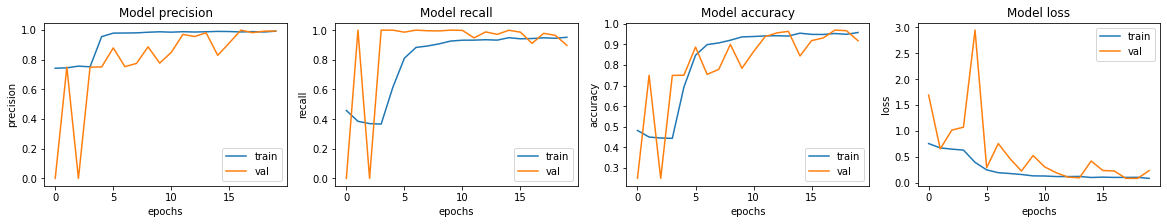
 

# 3. 회고

  - 어려웠던 점
    - 정상 이미지가 폐렴 이미지보다 많이 적어서 훈련이 제대로 안될 것 같았음
    - 이미지를 새로 생성하는 방법을 찾아봤지만 코드 호환이 잘 되지 않아 포기
    - 텐서플로우도 사람마다 작성하는 코드 양식이 다름
      - 코드를 읽으면서 입력하였지만 충돌이 일어나는 듯 : 오류 발생
      - 다른이가 작성한 코드를 참조하여 ResNet을 구현해볼려고 노력했지만 이것도 오류 발생
    - lms 자료를 모두 다시 입력하며 주어진 값들을 변경
      - 이미지 크기 조정 : (224, 224, 3), (196, 196, 3)을 변경하여 실행
      - 가중치 값들을 변경하면서 훈련시킴
      - 층을 새롭게 만들어볼려고 시도했지만 오류 발생
      - optimizer도 변경하여 결과 확인 : adam이 제일 결과값이 좋음
      
  - 느낀 점
    - 복사/붙여넣기가 아닌 코드를 모두 입력하니 예전보다 조금씩 나아지는 것 같음
    - 새로운 시도를 하기 위해 구글 검색을 하면서 좋은 자료를 많이 찾았음
      - 이렇게 찾아낸 자료를 보관하고 다음에 학습을 할 예정
    - 코드를 빨리 구현할 수 있는 능력을 기르자고 다짐함

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록 설정하는 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 root 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/chest_xray')

# batch_size
BATCH_SIZE = 25

# x_ray 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# epoch 크기 변수
EPOCHS = 20

print(ROOT_PATH)

/home/aiffel/aiffel/chest_xray


In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# filenames : train / validation data로 분할
train_filenames, val_filenames = train_test_split(filenames, test_size=0.3)

print(len(train_filenames), len(val_filenames))

3662 1570


In [5]:
count_normal = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(count_normal))

count_pneumonia = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(count_pneumonia))

count_val_normal = len([filename for filename in val_filenames if "NORMAL" in filename])
print("Normal images count in validation data set: " + str(count_val_normal))

count_val_pneumonia = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in validation data set: " + str(count_val_pneumonia))

Normal images count in training set: 956
Pneumonia images count in training set: 2706
Normal images count in validation data set: 393
Pneumonia images count in validation data set: 1177


In [6]:
# tf.data 인스턴스 만듬 
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 함

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()

In [8]:
class_names = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                       for item in tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*'))])
print(class_names)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == class_names[0]

In [10]:
# 이미지 크기를 통일 
# process_path 함수에서 decode_img 함수를 이용해서
#    이미지 데이터 타입을 float로 바꾸고 크기도 변경
#    get_label 함수를 호출하여 라벨값을 가져옴

def decode_img(img):
    # 이미지를 uint8 tensor로 변경
    img = tf.image.decode_jpeg(img, channels=3)
    
    # img를 범위 [0, 1]의 float32 데이터 타입으로 변경
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# num_parallel_calls 파라미터에서 AUTOTUNE를 이요하면 빠르게 데이터 처리

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 사이즈, 레이블 확인
for image, label in train_ds.take(1):
    print("image shape: ", image.numpy().shape)
    print("label: ", label.numpy())

image shape:  (224, 224, 3)
label:  True


In [13]:
# test data 

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
test_image_count = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(test_image_count)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
# prefetch() : 학습데이터를 나눠서 읽어옴
#    첫 번째 데이터가 GPU에서 학습하는 동안
#    두 번째 데이터를 CPU에서 준비함으로 리소스의 유휴상태를 줄임

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
    
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

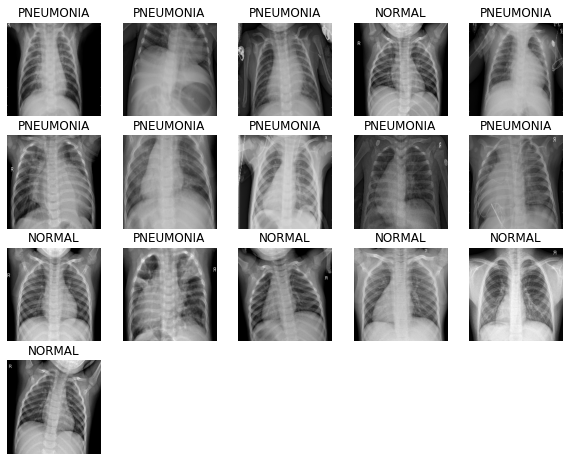

In [16]:
# data 시각화 
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
            
        plt.axis("off")
        
show_batch(image_batch.numpy(), label_batch.numpy())

## 층을 다시 쌓는 시도 / ResNet으로 시도
  - 오류발생
  - 하나씩 학습하며 시도했지만 오류 원인을 못찾아 포기
  - 다시 텐서플로우와 케라스를 공부하고 시도할 예정

In [17]:
# model = Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=(224, 224, 3), padding='same',
#                 kernel_initializer='random_normal', bias_initializer='zeros',
#                 kernel_regularizer=regularizers.l2(0.02),
#                 bias_regularizer=regularizers.l2(0.02)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='random_normal',
#                 bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.02),
#                 bias_regularizer=regularizers.l2(0.02)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
# model.add(Dropout(0.2))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(128, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(3,3)))
# model.add(Dropout(0.2))

# model.add(Flatten())

# model.add(Dense(512, activation='relu'))

# model.add(Dense(1000))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))
# model7 = model


In [18]:
# ResNet152V2 model for Pneumnia deep learning detection

# def createModel():
#     top_model = tf.keras.Sequential()
#     top_model = tf.keras.applications.ResNet152V2(include_top=True, 
#                     weights='imagenet', input_tensor=None, 
#                     input_shape=(224, 224, 3), pooling=None, classes=1000,
#                     )

#     top_model.add(ResNet152V2(include_top=(top_model)False, weights='imagenet',
#                              input_shape=(224, 224, 3)))
#     top_model = tf.keras.layers.(top_model)Add(reshape((7, 7, 2048), input_shape(-1, 7, 7, 2048)))
#     top_model = tf.keras.layers.Flatten()#(top_model)
#     top_model = tf.keras.layers.Dense(256, activation='relu')#(top_model)
#     top_model = tf.keras.layers.Dropout(0.5)#(top_model)
#     top_model = tf.keras.layers.Dense(512, activation='relu')#(top_model)
#     top_model = tf.keras.layers.BatchNormalization()#(top_model)
#     top_model = tf.keras.layers.Dropout(0.7)#(top_model)

#     top_model = tf.keras.layers.Dense(128, activation='relu')#(top_model)
#     top_model = tf.keras.layers.BatchNormalization()#(top_model)
#     top_model = tf.keras.layers.Dropout(0.5)#(top_model)

#     top_model = tf.keras.layers.Dense(64, activation='relu')#(top_model)
#     top_model = tf.keras.layers.BatchNormalization()#(top_model)
#     top_model = tf.keras.layers.Dropout(0.3)#(top_model)
        
#     top_model = tf.keras.layers.Dense(1, activation='sigmoid')#(top_model)
    
#     return top_model

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='sigmoid', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='sigmoid', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
#         tf.keras.applications.ResNet152V2(include_top=True, 
#                     weights='imagenet', input_tensor=None, 
#                     input_shape=(224, 224, 3), pooling=None, classes=1000,
#                     ),
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),  
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
weight_for_0 = (1.2/count_normal) * (train_img_count)/2.5
weight_for_1 = (0.75/count_pneumonia) * (train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(weight_for_0, weight_for_1)

1.8386610878661087 0.5074833702882483


In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='nadam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
# image_size = [224, 224]
# normal weights = 1.2 / pneumonia weights = 0.75
# train : val = 7 : 3  => 30%

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=train_img_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=val_img_count // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
146/146 [==============================] - 43s 291ms/step - loss: 0.7550 - accuracy: 0.4811 - precision: 0.7416 - recall: 0.4581 - val_loss: 1.6916 - val_accuracy: 0.2490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
146/146 [==============================] - 39s 267ms/step - loss: 0.6721 - accuracy: 0.4490 - precision: 0.7443 - recall: 0.3850 - val_loss: 0.6518 - val_accuracy: 0.7497 - val_precision: 0.7497 - val_recall: 1.0000
Epoch 3/20
146/146 [==============================] - 39s 266ms/step - loss: 0.6474 - accuracy: 0.4444 - precision: 0.7557 - recall: 0.3695 - val_loss: 1.0160 - val_accuracy: 0.2477 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
146/146 [==============================] - 39s 266ms/step - loss: 0.6294 - accuracy: 0.4427 - precision: 0.7511 - recall: 0.3664 - val_loss: 1.0711 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 5/20
146/146 [==============================] - 38s 261ms/step - loss:

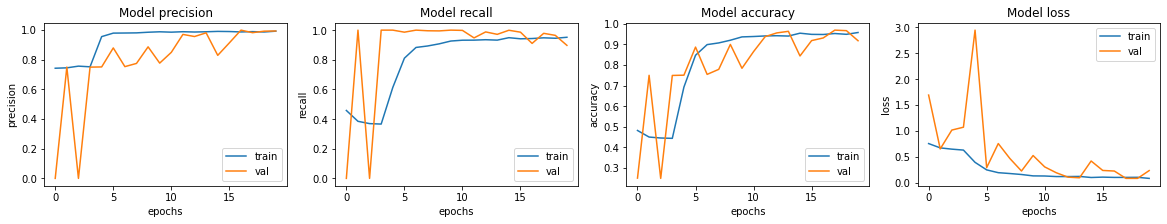

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

25/25 [==============================] - 18s 717ms/step - loss: 0.4406 - accuracy: 0.8782 - precision: 0.8848 - recall: 0.9256


In [21]:
# image_size = [224, 224]
# optimizer = adam
# weights = 1.5
# train : val = 3 : 1  => 25%

# with tf.device('/GPU:0'):
#     history = model.fit(
#         train_ds,
#         steps_per_epoch=train_img_count // BATCH_SIZE,
#         epochs=EPOCHS,
#         validation_data=val_ds,
#         validation_steps=val_img_count // BATCH_SIZE,
#         class_weight=class_weight,
#     )

Epoch 1/20
156/156 [==============================] - 48s 306ms/step - loss: 1.0592 - accuracy: 0.4700 - precision: 0.7532 - recall: 0.4158 - val_loss: 1.1638 - val_accuracy: 0.2392 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
156/156 [==============================] - 43s 276ms/step - loss: 0.9633 - accuracy: 0.4174 - precision: 0.7421 - recall: 0.3197 - val_loss: 0.8069 - val_accuracy: 0.2385 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
156/156 [==============================] - 43s 275ms/step - loss: 0.9355 - accuracy: 0.3954 - precision: 0.7300 - recall: 0.2858 - val_loss: 0.8951 - val_accuracy: 0.2385 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
156/156 [==============================] - 43s 274ms/step - loss: 0.9076 - accuracy: 0.3810 - precision: 0.7313 - recall: 0.2489 - val_loss: 0.9718 - val_accuracy: 0.2369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
156/156 [==============================] - 43s 27

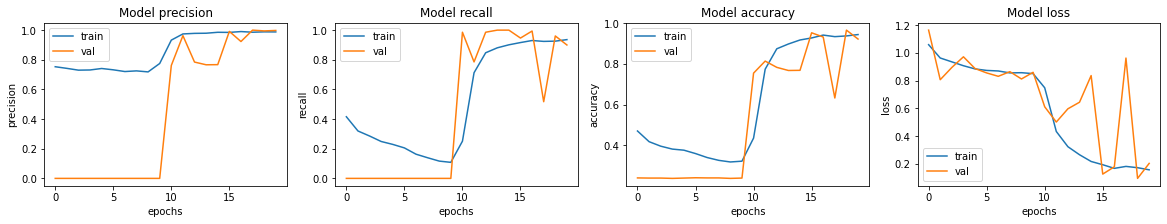

In [22]:
# fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#     ax[i].plot(history.history[met])
#     ax[i].plot(history.history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

25/25 [==============================] - 4s 171ms/step - loss: 0.5592 - accuracy: 0.7933 - precision: 0.7736 - recall: 0.9462


image_size = [224, 224]

weight_for_0 = (1.5/count_normal) * (train_img_count)/2.0  
weight_for_1 = (1/count_pneumonia) * (train_img_count)/2.0  


  
def augment(image,label):  

    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.  
    
    return image,label


In [22]:
# with tf.device('/GPU:0'):
#     history = model.fit(
#         train_ds,
#         steps_per_epoch=train_img_count // BATCH_SIZE,
#         epochs=EPOCHS,
#         validation_data=val_ds,
#         validation_steps=val_img_count // BATCH_SIZE,
#         class_weight=class_weight,
#     )

Epoch 1/20
156/156 [==============================] - 49s 316ms/step - loss: 1.0763 - accuracy: 0.4505 - precision: 0.7377 - recall: 0.4003 - val_loss: 0.8780 - val_accuracy: 0.2515 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
156/156 [==============================] - 44s 282ms/step - loss: 0.9706 - accuracy: 0.4005 - precision: 0.7250 - recall: 0.3045 - val_loss: 0.5634 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/20
156/156 [==============================] - 44s 282ms/step - loss: 0.9246 - accuracy: 0.3985 - precision: 0.7334 - recall: 0.2922 - val_loss: 0.5662 - val_accuracy: 0.7492 - val_precision: 0.7492 - val_recall: 1.0000
Epoch 4/20
156/156 [==============================] - 44s 279ms/step - loss: 0.9123 - accuracy: 0.3808 - precision: 0.7295 - recall: 0.2612 - val_loss: 0.7750 - val_accuracy: 0.2508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
156/156 [==============================] - 43s 277ms/step - loss:

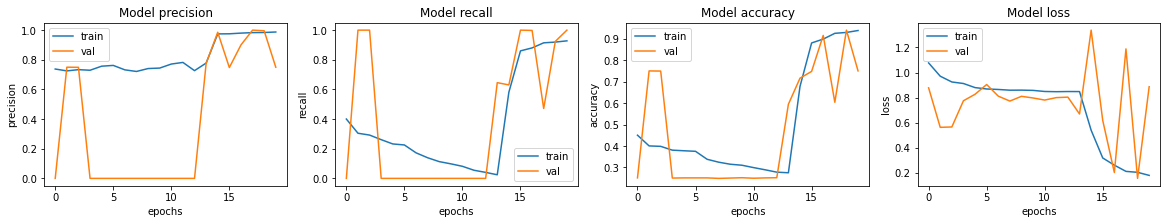

In [23]:
# fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#     ax[i].plot(history.history[met])
#     ax[i].plot(history.history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])

In [24]:
# loss, acc, prec, rec = model.evaluate(test_ds)

25/25 [==============================] - 21s 840ms/step - loss: 1.6758 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
